In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn import metrics
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.model_selection import train_test_split as time_train_test_split
from xgboost import XGBRegressor
from xgboost import plot_importance
from datetime import timedelta


import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df_month = pd.read_csv(
    './data/Road Crash Statistics in Quezon City (2018-2022) - Classification by Month per case basis .csv' , index_col=False)
df_hour = pd.read_csv(
    './data/Road Crash Statistics in Quezon City (2018-2022) - Classification by Time of Day.csv', index_col=False )

In [3]:
df_month.head()

,Year,Month,Damage to Property,Fatal,Non Fatal Injury,Grand Total
0,2018,January,2743,7,403,3153
1,2018,February,2621,7,423,3051
2,2018,March,2711,12,475,3198
3,2018,April,2573,7,417,2997
4,2018,May,2721,10,432,3163


In [4]:
df_hour.head()

,Year,Time Hour,Damage to Property,Fatal,Non Fatal Injury,Grand Total
0,2018,00:00-00:59,599,3.0,162,764
1,2018,01:00-01:59,551,8.0,132,691
2,2018,02:00-02:59,469,7.0,130,606
3,2018,03:00-03:59,449,12.0,128,589
4,2018,04:00-04:59,565,12.0,140,717


## Title: Data Cleaning

In [5]:
DEPENDENT_VARIABLE = "Grand Total"

In [6]:
df_month[DEPENDENT_VARIABLE] =df_month[DEPENDENT_VARIABLE].fillna(0)
df_month[DEPENDENT_VARIABLE] = df_month[DEPENDENT_VARIABLE].apply(
    lambda x: 0 if x == 0 or x == '' or x == ' ' 
    else float ( 
        str(x).replace(',','').replace('',''))
    )

In [7]:
df_hour[DEPENDENT_VARIABLE] =df_hour[DEPENDENT_VARIABLE].fillna(0)
df_hour[DEPENDENT_VARIABLE] = df_hour[DEPENDENT_VARIABLE].apply(
    lambda x: 0 if x == 0 or x == '' or x == ' ' 
    else float ( 
        str(x).replace(',','').replace('',''))
    )

In [8]:
df_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                60 non-null     int64  
 1   Month               60 non-null     object 
 2   Damage to Property  60 non-null     int64  
 3   Fatal               60 non-null     int64  
 4   Non Fatal Injury    60 non-null     int64  
 5   Grand Total         60 non-null     float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.9+ KB


In [9]:
df_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                125 non-null    int64  
 1   Time Hour           125 non-null    object 
 2   Damage to Property  125 non-null    int64  
 3   Fatal               121 non-null    float64
 4   Non Fatal Injury    125 non-null    int64  
 5   Grand Total         125 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 6.0+ KB


In [10]:
df_month.describe()

,Year,Damage to Property,Fatal,Non Fatal Injury,Grand Total
count,60.000000,60.000000,60.000000,60.000000,60.000000
mean,2020.000000,2012.816667,9.400000,460.300000,2482.516667
std,1.426148,735.276738,3.092912,83.087314,777.578063
min,2018.000000,249.000000,1.000000,164.000000,414.000000
25%,2019.000000,1444.250000,7.000000,416.500000,1842.500000
50%,2020.000000,1834.500000,10.000000,456.500000,2348.000000
75%,2021.000000,2725.750000,11.000000,518.000000,3186.750000
max,2022.000000,3162.000000,18.000000,648.000000,3711.000000


In [11]:
df_hour.describe()

,Year,Damage to Property,Fatal,Non Fatal Injury,Grand Total
count,125.000000,125.000000,121.000000,125.000000,125.000000
mean,2020.000000,966.152000,4.661157,220.944000,1191.608000
std,1.419905,561.889354,2.706639,82.841697,621.695223
min,2018.000000,13.000000,1.000000,10.000000,25.000000
25%,2019.000000,481.000000,3.000000,166.000000,674.000000
50%,2020.000000,1004.000000,4.000000,239.000000,1262.000000
75%,2021.000000,1283.000000,6.000000,275.000000,1508.000000
max,2022.000000,2095.000000,14.000000,420.000000,2384.000000


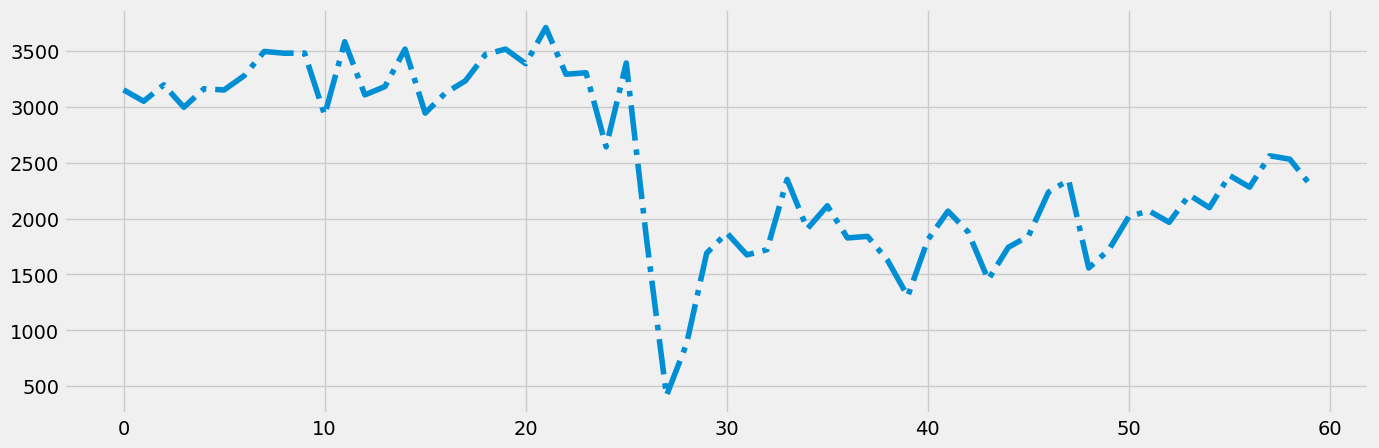

In [12]:
df_month[DEPENDENT_VARIABLE].plot(style='-.',
                        figsize=(15, 5),
                        )
plt.show()

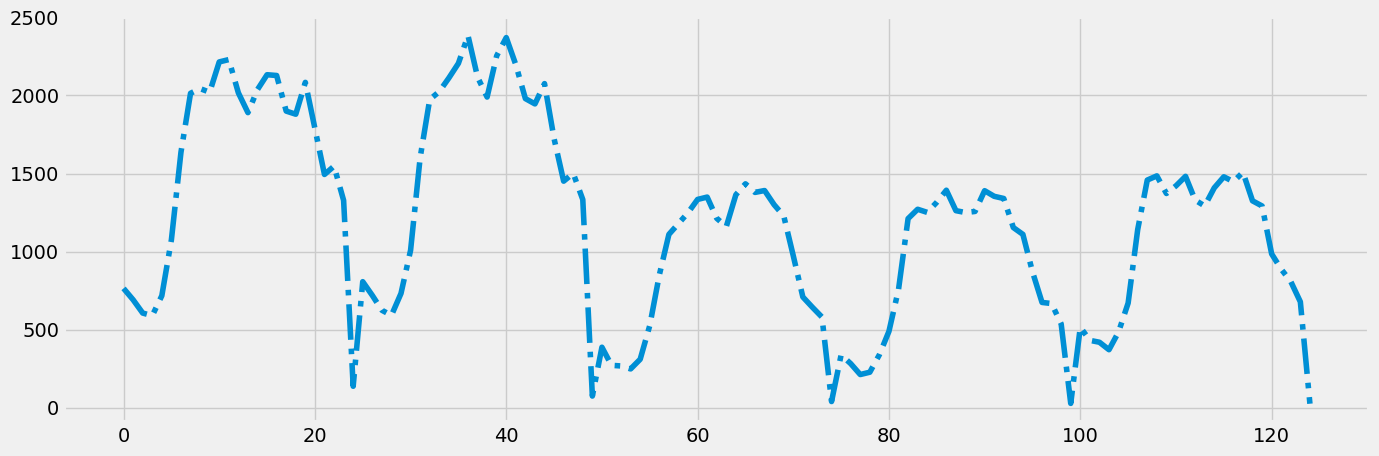

In [13]:
df_hour[DEPENDENT_VARIABLE].plot(style='-.',
                        figsize=(15, 5),
                        )
plt.show()

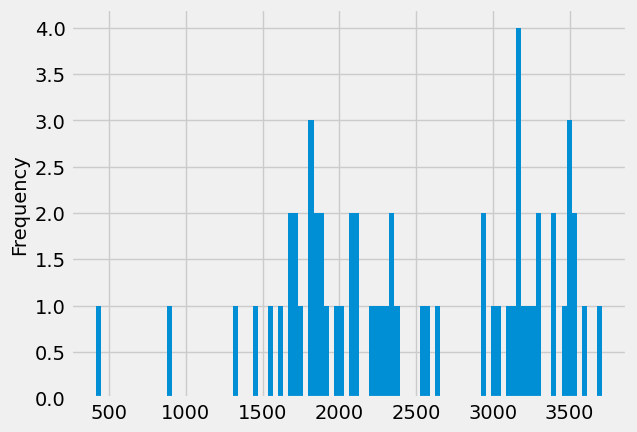

In [14]:
df_month[DEPENDENT_VARIABLE].plot(kind='hist', bins=100);

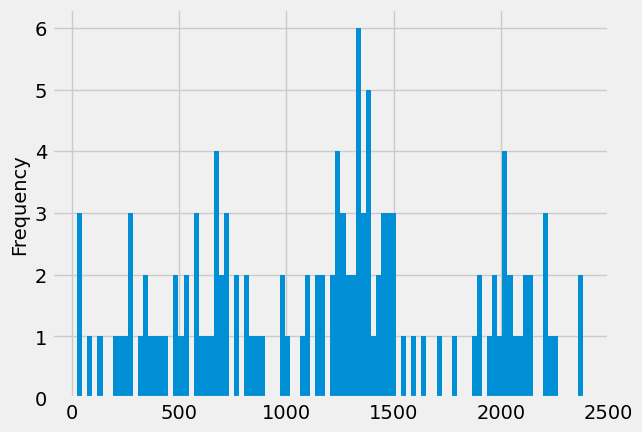

In [15]:
df_hour[DEPENDENT_VARIABLE].plot(kind='hist', bins=100);

In [16]:
# ----------- Hour -----------
df_hour_X = df_hour.copy()

# Test Size = 20%
train_hour, test_hour = time_train_test_split(df_hour_X, test_size=int(len(df_month)*0.42))

train_hour = pd.DataFrame(train_hour)
test_hour = pd.DataFrame(test_hour)

# ----------- Monthly -----------
df_month_X = df_month.copy()

# Test Size = 20%
train_month, test_month = time_train_test_split(df_month_X, test_size=int(len(df_month)*0.2))

train_month = pd.DataFrame(train_month)
test_month = pd.DataFrame(test_month)


In [17]:
test_hour.head(24)

,Year,Time Hour,Damage to Property,Fatal,Non Fatal Injury,Grand Total
100,2022,00:00-00:59,342,7.0,166,515.0
101,2022,01:00-01:59,275,10.0,146,431.0
102,2022,02:00-02:59,263,7.0,149,419.0
103,2022,03:00-03:59,232,7.0,132,371.0
104,2022,04:00-04:59,297,6.0,182,485.0
105,2022,05:00-05:59,397,5.0,268,670.0
106,2022,06:00-06:59,749,8.0,384,1141.0
107,2022,07:00-07:59,1033,5.0,420,1458.0
108,2022,08:00-08:59,1087,1.0,397,1485.0
109,2022,09:00-09:59,1055,4.0,313,1372.0


In [18]:
test_month.head(12)

,Year,Month,Damage to Property,Fatal,Non Fatal Injury,Grand Total
48,2022,January,1086,15,457,1558.0
49,2022,February,1289,10,422,1721.0
50,2022,March,1492,7,521,2020.0
51,2022,April,1523,7,539,2069.0
52,2022,May,1504,7,456,1967.0
53,2022,June,1602,10,600,2212.0
54,2022,July,1563,12,523,2098.0
55,2022,August,1826,16,545,2387.0
56,2022,September,1730,10,542,2282.0
57,2022,October,1938,11,614,2563.0


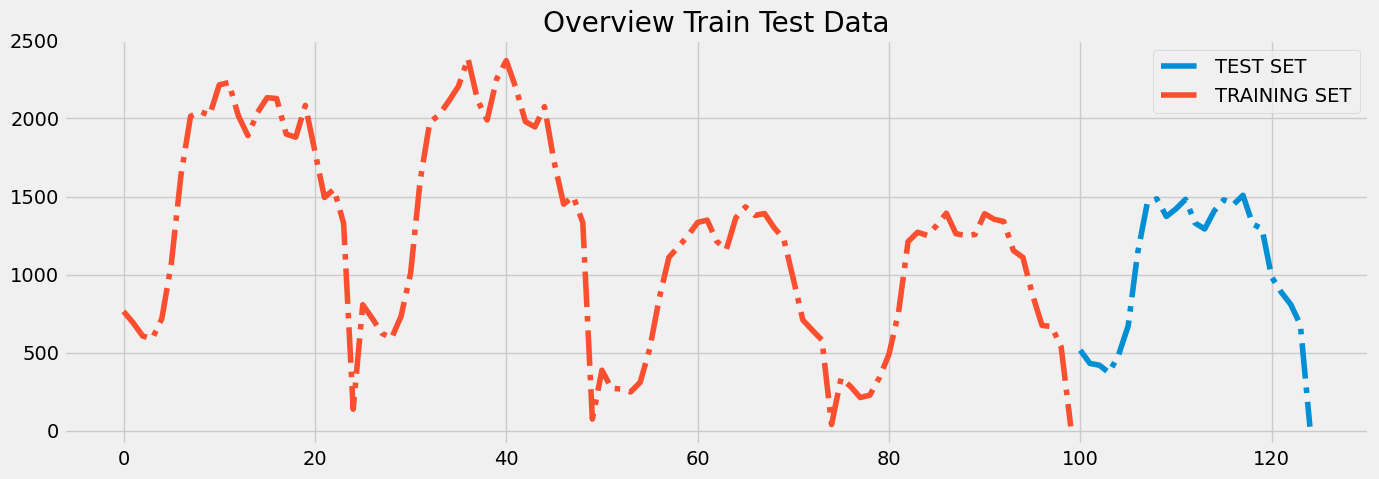

In [19]:
overview_Train_Test_Data = test_hour[[DEPENDENT_VARIABLE]].rename(columns={DEPENDENT_VARIABLE: 'TEST SET'}) .join( train_hour[[DEPENDENT_VARIABLE]].rename(columns={DEPENDENT_VARIABLE: 'TRAINING SET'}), how='outer').plot(figsize=(15,5), title='Overview Train Test Data', style='-.')

In [20]:
train_month.head()

,Year,Month,Damage to Property,Fatal,Non Fatal Injury,Grand Total
0,2018,January,2743,7,403,3153.0
1,2018,February,2621,7,423,3051.0
2,2018,March,2711,12,475,3198.0
3,2018,April,2573,7,417,2997.0
4,2018,May,2721,10,432,3163.0


In [21]:
train_hour.head()

,Year,Time Hour,Damage to Property,Fatal,Non Fatal Injury,Grand Total
0,2018,00:00-00:59,599,3.0,162,764.0
1,2018,01:00-01:59,551,8.0,132,691.0
2,2018,02:00-02:59,469,7.0,130,606.0
3,2018,03:00-03:59,449,12.0,128,589.0
4,2018,04:00-04:59,565,12.0,140,717.0


In [22]:
dtime_day = {
    "00:00-00:59": "Night",
    "01:00-01:59": "Night",
    "02:00-02:59": "Night",
    "03:00-03:59": "Night",
    "04:00-04:59": "Night",
    "05:00-05:59": "Morning",
    "06:00-06:59": "Morning",
    "07:00-07:59": "Morning",
    "08:00-08:59": "Morning",
    "09:00-09:59": "Morning",
    "10:00-10:59": "Morning",
    "11:00-11:59": "Morning",
    "12:00-12:59": "Afternoon",
    "13:00-13:59": "Afternoon",
    "14:00-14:59": "Afternoon",
    "15:00-15:59": "Afternoon",
    "16:00-16:59": "Afternoon",
    "17:00-17:59": "Afternoon",
    "18:00-18:59": "Evening",
    "19:00-19:59": "Evening",
    "20:00-20:59": "Night",
    "21:00-21:59": "Night",
    "22:00-22:59": "Night",
    "23:00-23:59": "Night",
    "Time Not Stated": "unkown",
}

# 0 - Not rush hour 
# 1 - Rush hour
'''
Worst traffic is at 7AM to 9AM and on 5PM to 9PM
Medium traffic is at 9AM to 10AM and on 9PM to 11PM
Low Traffic rest of the Hour
'''
rush_hour = {
    "00:00-00:59":  "Low",
    "01:00-01:59":  "Low",
    "02:00-02:59": "Low",
    "03:00-03:59": "Low",
    "04:00-04:59": "Low",
    "05:00-05:59": "Low",
    "06:00-06:59": "Low",
    "07:00-07:59": "High",
    "08:00-08:59": "High",
    "09:00-09:59": "Medium",
    "10:00-10:59": "Low",
    "11:00-11:59": "Low",
    "12:00-12:59": "Low",
    "13:00-13:59": "Low",
    "14:00-14:59": "Low",
    "15:00-15:59": "Low",
    "16:00-16:59": "Low",
    "17:00-17:59": "High",
    "18:00-18:59": "High",
    "19:00-19:59": "High",
    "20:00-20:59": "High",
    "21:00-21:59": "Medium",
    "22:00-22:59": "Medium",
    "23:00-23:59": "Medium",
    "Time Not Stated": "Neutral",
}
from dateutil.relativedelta import relativedelta, MO
def create_features_monthly(df, target_variable):
    df['Year'] = df['Year'].apply(lambda x: int(x))
    X = df[[
        'Year', 'Month'
    ]]
    X = pd.get_dummies(X, columns = ['Month'])
    if target_variable:
        y = df[target_variable]
        return X, y
    return X


def create_features_hourly(df, target_variable):
    def hourmin_decimal(time, index):
        if time == 'Time Not Stated': 
            return -1 
        time = time.split('-')[index].split(':')
        hour = int(time[0])
        minutes = int(time[-1])
        return int(hour) * 3600 + int(minutes) * 60

    df['Year'] = df['Year'].apply(lambda x: int(x))
    df['Day Time'] = df['Time Hour'].apply(lambda x:  dtime_day[x])
    df['Hour Start'] = df['Time Hour'].apply(lambda x: hourmin_decimal(x,0))
    df['Hour End'] = df['Time Hour'].apply(lambda x: hourmin_decimal(x,-1))
    df['Traffic'] = df['Time Hour'].apply(lambda x: rush_hour[x])
    X = df[[
        'Year', 'Day Time', 'Hour Start', 'Hour End', 'Traffic'
    ]]
    X = pd.get_dummies(X, columns = ['Day Time', 'Traffic'])
    if target_variable:
        y = df[target_variable]
        return X, y
    return X



def mean_absolute_percentage_error_func(y_true, y_pred):
    '''
    Calculate the mean absolute percentage error as a metric for evaluation
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        Mean absolute percentage error 
    '''    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    return mape


def timeseries_evaluation_metrics_func(y_true, y_pred):
    '''
    Calculate the following evaluation metrics:
        - MSE
        - MAE
        - RMSE
        - MAPE
        - R²
    
    Args:
        y_true (float64): Y values for the dependent variable (test part), numpy array of floats 
        y_pred (float64): Predicted values for the dependen variable (test parrt), numpy array of floats
    
    Returns:
        MSE, MAE, RMSE, MAPE and R² 
    '''    
    #print('Evaluation metric results: ')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error_func(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')


In [23]:
train_hour_copy = train_hour.copy()
test_hour_copy = test_hour.copy()

hour_trainX, hour_trainY = create_features_hourly(train_hour_copy, target_variable=DEPENDENT_VARIABLE)
hour_testX, hour_testY = create_features_hourly(test_hour_copy, target_variable=DEPENDENT_VARIABLE)

In [24]:
train_month_copy = train_month.copy()
test_month_copy = test_month.copy()

month_trainX, month_trainY = create_features_monthly(train_month_copy, target_variable=DEPENDENT_VARIABLE)
month_testX, month_testY = create_features_monthly(test_month_copy, target_variable=DEPENDENT_VARIABLE)

In [25]:
hour_trainX.head()

,Year,Hour Start,Hour End,Day Time_Afternoon,Day Time_Evening,Day Time_Morning,Day Time_Night,Day Time_unkown,Traffic_High,Traffic_Low,Traffic_Medium,Traffic_Neutral
0,2018,0,3540,0,0,0,1,0,0,1,0,0
1,2018,3600,7140,0,0,0,1,0,0,1,0,0
2,2018,7200,10740,0,0,0,1,0,0,1,0,0
3,2018,10800,14340,0,0,0,1,0,0,1,0,0
4,2018,14400,17940,0,0,0,1,0,0,1,0,0


In [26]:
hour_trainY

0     764.0
1     691.0
2     606.0
3     589.0
4     717.0
      ...  
95    871.0
96    674.0
97    667.0
98    536.0
99     27.0
Name: Grand Total, Length: 100, dtype: float64

In [27]:
month_trainX.head()

,Year,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
0,2018,0,0,0,0,1,0,0,0,0,0,0,0
1,2018,0,0,0,1,0,0,0,0,0,0,0,0
2,2018,0,0,0,0,0,0,0,1,0,0,0,0
3,2018,1,0,0,0,0,0,0,0,0,0,0,0
4,2018,0,0,0,0,0,0,0,0,1,0,0,0
